In [1]:
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
# style.use('default')
style.use('S:\Connie\prx.mplstyle')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Getting ideal rho

In [4]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

"""
Define basis in to be used when doing MLE
"""
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [5]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
psi_basis_3q = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
S123 = 'ZZZ'
S1, S2, S3 = S123
psi1 = psi_dict[S1]
psi2 = psi_dict[S2]
psi3 = psi_dict[S3]

psi_basis_3q.update({S123:[]})

for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis_3q[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())
calib_order_numeric_3q = ['000', '001', '010', '011', '100', '101', '110', '111']
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric_3q):
    psis.update({label_numeric:psi_basis_3q['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

def get_qram_qSLR_state_from_rho(init_rho_IS, output_qubits, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    outputs partial trace of qram output (needs output_qubits to all be in 0, 2, and/or 3 to work)
    """
    # in order |00>, |01>, |10>, |11> for switch, input
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.all([q in [0, 2, 3] for q in output_qubits])
    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print(f'constructing final state on |Q{output_qubits[0]}, Q{output_qubits[1]}>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    output_indices = [[0,2,3].index(q) for q in output_qubits]
    return qt.ptrace(rho_final_SLR.unit(), output_indices)

# Run experiment and analysis

In [6]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [7]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [8]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_250119')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [9]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [11]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=2)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [12]:
# ns_address = '10.108.30.56' # Spilker Fermium
ns_address = '10.108.30.75' # Spilker Vibranium
im = InstrumentManager(ns_address=ns_address)

In [13]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq*1e-6, 'MHz')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power, 'dBm')

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1804348)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

## Test 2Q tomo

In [33]:
tomo_qubits = [0, 2] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
tomoExpt.save_data()

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
tomo = tomoExpt

# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
cfg = tomo.cfg
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

## Test 2Q optimal control pulses

In [364]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


240920_qram_4q_2qubit_+egg
dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])
IQ_qubits [0, 1]


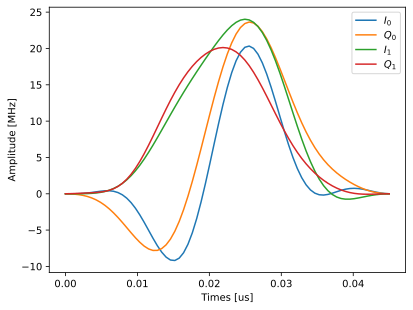

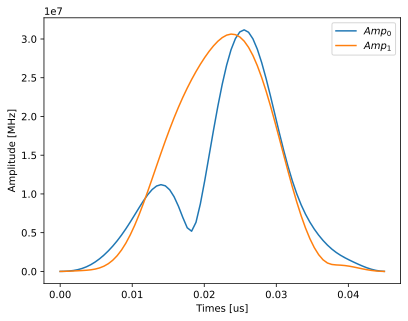

In [365]:
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_1p.filename
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_p1.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
print(pulse_filename)

pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

plt.figure()
plt.plot(times*1e6, np.abs(I_0+1j*Q_0), label='$Amp_0$')
plt.plot(times*1e6, np.abs(I_1+1j*Q_1), label='$Amp_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

In [54]:
tomo_qubits = [0, 1] # which qubits to do tomo on

# init_state = '|0+1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
# init_state = '|1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
init_state = '|0+1>|1>' # this is just for reference when doing the 2Q tomo comparison

readout_cool = True

In [367]:
centers = [3000, 5200]
spans = [2000, 2000]
# spans = [500, 500]
npts = [6, 6]

# centers = [4100, 5100]
# spans = [0, 0]
# npts = [1, 1]

centers = np.array(centers)
spans = np.array(spans)
npts = np.array(npts)
print('number points', (npts[0]+1)*(npts[1]+1))

tomoExpt = meas.OptimalCtrlTomo2QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"OptimalCtrlTomo2Q_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    starts=(centers-spans/2).astype(int), # start gain for each qubit in IQ_qubits
    steps=(spans/npts).astype(int),
    expts=npts+1,
    reps=5000, # reps per measurement basis
    # reps=100, # reps per measurement basis
    singleshot_reps=15000, # reps for single shot calib
    # singleshot_reps=1000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    
    Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
    Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
    times_us=times_us,
    IQ_qubits=IQ_qubits,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=10,
   
    # thresholds=[530.1641328860773, 298.0622274040452, 0, 0],
    # angles=[-156.06235175077572, -177.6596617753593, 0, 0],
    # ge_avgs=[[-442.594915, -279.7363071627907, -914.3632173488371, -39.117149279069764], [-177.4867981416169, 198.44441421595226, -387.54766318502436, 200.4889138632664], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[15698, 2664, 1281, 357], [3353, 14690, 562, 1395], [1904, 406, 14898, 2792], [820, 1603, 3297, 14280]]
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

number points 49
gainpts Q0 [2000 2333 2666 2999 3332 3665 3998]
gainpts Q1 [4200 4533 4866 5199 5532 5865 6198]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.66922230741025 	 angle (deg): 26.03327721940717 	 threshold ge: 312.0803289891335
Qubit (1)
ge fidelity (%): 53.900000000000006 	 angle (deg): -173.43104307957515 	 threshold ge: 408.0059907231424


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 80.14 	 angle (deg): 155.72747849360348 	 threshold ge: 490.2627886037599


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 75.26666666666667 	 angle (deg): 29.431008995938555 	 threshold ge: 76.64195865903628
thresholds=[312.0803289891335, 408.0059907231424, 490.2627886037599, 76.64195865903628],
angles=[26.03327721940717, -173.43104307957515, 155.72747849360348, 29.431008995938555],
ge_avgs=[[199.03519633969907, 85.0020259837963, 540.181451461227, -83.35677699652778], [-296.75081434461805, -95.21728838975694, -508.2667942274306, -68.54649733072917], [-123.88178407118056, -398.12985993923616, -510.5924571180556, -594.4715744791666], [179.27013018663197, 433.4731576171875, 500.20205553385415, 250.7809875]],
counts_calib=[[11409, 2199, 970, 422], [3815, 9681, 522, 982], [1715, 394, 9893, 2998], [817, 1527, 2300, 10356]]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [368]:
pulse_dict = tomoExpt.pulse_dict
tomoExpt.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00220_OptimalCtrlTomo2Q_01.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00220_OptimalCtrlTomo2Q_01.h5'

In [369]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

init_state |0+1>|1>
Using evol mats from file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_01.npz
2000 4200 fid 0.7900935947103881 purity 0.9264454457985281
2000 4533 fid 0.7252161930390134 purity 0.8231540847372207


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 757ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 762

2000 4866 fid 0.8096309724414746 purity 0.8898649511788913
2000 5199 fid 0.8350459024922657 purity 0.8867231663415802
2000 5532 fid 0.8672691344765677 purity 0.9323344636694888
2000 5865 fid 0.7098493244203479 purity 0.7273143716327338
2000 6198 fid 0.82624686324649 purity 0.9152988591225367
2333 4200 fid 0.8246409787190135 purity 0.9999999999999989
2333 4533 fid 0.8786613117637943 purity 0.9917800380852212
2333 4866 fid 0.8295685160958223 purity 0.7779749029279631
2333 5199 fid 0.8980605779608543 purity 0.9434951297632973
2333 5532 fid 0.8454612584773566 purity 0.84982735787441
2333 5865 fid 0.8277355548988974 purity 0.8739597963854973
2333 6198 fid 0.8006882533941494 purity 0.8561253487969542
2666 4200 fid 0.7518277412037819 purity 1.0000000000000002
2666 4533 fid 0.8515566056677963 purity 0.8583551170326805
2666 4866 fid 0.8813545311852964 purity 0.8821644736850136
2666 5199 fid 0.9007145082293949 purity 0.9316244804477191
2666 5532 fid 0.9042071647230624 purity 0.922449755467669
26

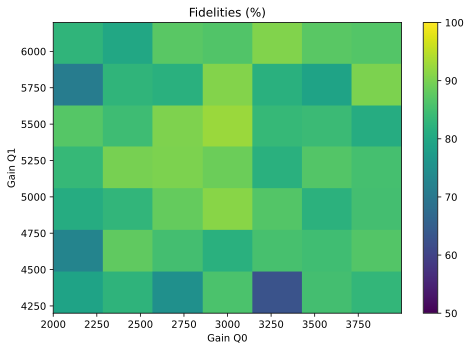

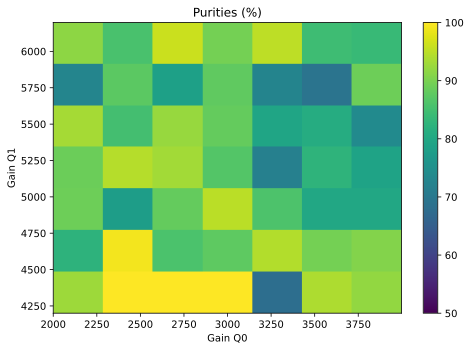

In [370]:
tomo = tomoExpt

# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
print('init_state', init_state)
rho_id = qt.ket2dm(name_to_state_2q(init_state))

# filename = 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00023_OptimalCtrlTomo2Q_01.h5'
# tomo = meas.OptimalCtrlTomo2QExperiment(config_file=config_path)
# data, attrs = prev_data(filename, None)
# tomo.data = data
# tomo.cfg = AttrDict(attrs['config'])
# pulse_dict = attrs['pulse_dict']

q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})


data = tomo.data
cfg = tomo.cfg

gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
fids_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))
purities_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))

for igain0, gain0 in enumerate(gainpts0):
    for igain1, gain1 in enumerate(gainpts1):
        if apply_ps:
            n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
                data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
                ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
                apply_ps=apply_ps, verbose=False)
        else:
            n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
            n_calib = data['counts_calib']
        
        rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
            n_tomo_raw=n_tomo_raw,
            n_calib=n_calib,
            correct_readout=True,
            correct_neg_counts=True,
            method='analytical',
            ZZ_correction=True,
            evol_mats=evol_mats,
        )
        fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
        purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
        
        fids_grid[igain1, igain0] = fid_ZZ
        purities_grid[igain1, igain0] = purity_ZZ
        print(gain0, gain1, 'fid', fid_ZZ, 'purity', purity_ZZ)

x_sweep = gainpts0
y_sweep = gainpts1

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Fidelities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(fids_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Purities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(purities_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

Pick one gain to plot tomo for

In [371]:
gain0 = 3000 # x axis
gain1 = 5532 # y axis

tomo = tomoExpt
cfg = tomo.cfg

data = tomo.data
gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
igain0 = np.argmin(np.abs(gainpts0-gain0)) 
igain1 = np.argmin(np.abs(gainpts1-gain1)) 
print('plotting at gain Q0', gainpts0[igain0], 'Q1', gainpts1[igain1])
print('expected fid', fids_grid[igain1, igain0])
print('expected purity', purities_grid[igain1, igain0])
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

if apply_ps:
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
        data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
        ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
        apply_ps=apply_ps, verbose=False)
else:
    n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
    n_calib = data['counts_calib']

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

plotting at gain Q0 2999 Q1 5532
expected fid 0.9243577344888096
expected purity 0.8820013485423933
Tomography counts
[[ 200.  836.  161.  571.]
 [ 627.  456.  336.  395.]
 [ 577.  468.  319.  404.]
 [ 429. 1115.   58.  228.]
 [ 796.  700.  122.  154.]
 [ 792.  747.  143.  159.]
 [ 310. 1176.   72.  249.]
 [ 762.  680.  137.  172.]
 [ 769.  644.  149.  166.]]
Confusion matrix counts
[[4304.  812.  154.   67.]
 [1355. 3628.   60.  173.]
 [ 376.   90. 3683. 1054.]
 [ 151.  417.  819. 3805.]]
Confusion matrix corrected tomo matrix will be
[[-153.75047 1151.69445   55.8385   714.21752]
 [ 564.15601  460.84916  343.01288  399.98195]
 [ 508.45598  503.90887  325.99543  429.63972]
 [  16.26822 1518.45078    2.36374  230.91726]
 [ 702.85297  832.61935  100.31745  132.21024]
 [ 646.30038  872.67826  126.08352  122.93783]
 [-170.35711 1661.63803   22.89941  253.81967]
 [ 673.94588  818.80759  120.05849  155.18804]
 [ 709.0675   771.88676  141.4794   145.56635]]
Negative counts corrected tomo mat

## Qram experiment

In [14]:
# tomo_qubits = [0, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 2] # which qubit/resonators to do tomo on
tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

In [15]:
save_data = False

In [16]:
init_state = '|1>|0+1>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'
# init_state = '|1>|1>' # Q0/Q1 (switch, input)
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 1, 4, 3]
# play_pulses = [2]*8 # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

# cool_qubits = [0, 1]
cool_qubits = None

readout_cool = False
full_mux_expt = True
resonator_reset = [0, 2, 3]

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

post_select = False # this is not the readout post selection

# add_phase = True # phase for swaps
add_phase = False
print('init_state', init_state)
print('post select', post_select)

init_state |1>|0+1>
post select False


In [18]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)
print('init state', init_state)
saved_files = []

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
        ns_address=ns_address,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        # reps=1000000, # number of reps per time step,
        reps=10000, # number of reps per time step,
        # singleshot_reps=10, # reps per state for singleshot calibration
        singleshot_reps=10000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses,
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
        use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
        plot_IQ=False,
        
        add_phase=add_phase,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=2,
        
        full_mux_expt=full_mux_expt,
        resonator_reset=resonator_reset,
        
        # meas_order=['XX'],
        
        # Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
        # Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
        # times_us=times_us,
        # IQ_qubits=IQ_qubits,
        # IQ_gain=[3700, 3950],
        
        # thresholds=[33.169103683345895, 37.49913270024612, 0, 0],
        # angles=[-24.579056838557847, 115.19639444481155, 0, 0],
        # ge_avgs=[[34.43056101813111, -9.525004532775455, 44.589988819153874, -4.651175313807532], [30.053312459336368, -50.17723301886793, 25.548312166558233, -59.65660634352635], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[12553, 5207, 1604, 636], [4673, 12956, 666, 1705], [2241, 876, 12383, 4500], [918, 2095, 4712, 12275]]
 
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    qramExpts.append(qramExpt)
    if save_data: saved_files.append(qramExpt.save_data())

TOMO QUBITS [0, 1]
init state |1>|0+1>


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 81.3992579257926 	 angle (deg): 0.0 	 threshold ge: 981.3865437121162
Qubit (1)
ge fidelity (%): 46.84999999999998 	 angle (deg): 0.0 	 threshold ge: 1133.6333772856133
thresholds=[981.3865437121162, 1133.6333772856133, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.6205959316517495, 1.7629946297803085, 2.0008698128559823, -0.8476379170056966], [429.1301867371847, 779.5735119609438, 548.4438690805534, 1152.1870986981285], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6877, 2342, 589, 192], [2487, 6402, 308, 803], [750, 334, 4668, 4248], [377, 761, 2561, 6301]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 554  533 3987 4926]
ZX [ 661  417 4867 4055]
ZY [ 680  490 4360 4470]
XZ [2257 2523 2436 2784]
XX [3264 1508 2470 2758]
XY [3103 1693 2902 2302]
YZ [2587 2309 2197 2907]
YX [3935 1410 2532 2123]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.24s/it]

YY [3550 1516 2843 2091]


In [85]:
qramExpt.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00119_qram_protocol.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00119_qram_protocol.h5'

### post processing average counts

In [19]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]


postselect = False # this is not the readout post selection
postselect_state = 1 # select on Q1 being 0 (-) or 1 (+)

In [20]:
cfg = qramExpt.cfg
print('init state', qramExpt.cfg.expt.init_state)
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    if postselect and qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps{postselect_state}'])
        n_calib = np.array(data['counts_calib'])
        print(f'Just getting states from post selection value of {postselect_state}')
    elif postselect and not qramExpt.cfg.expt.post_select:
        assert False, 'You are trying to post select but the experiment was not run with the post select flag=True!'
    elif qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps0'] + data[f'counts_tomo_ps1'])
        n_calib = np.array(data['counts_calib'])
    else:
        n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
    
    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)

pulse_dict = qramExpts[-1].pulse_dict
# print(pulse_dict)

init state |1>|0+1>


In [21]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
# n_tomo_corrected = tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
print('num rounds', len(n_tomo_raw_rounds))

print('Measure order', tomo_analysis.meas_order)

print('Average raw tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
# print('Std raw tomography counts')
# print(n_tomo_raw_std)
print('Average confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Corrected counts')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=3))
# print('Std confusion matrix counts')
# print(n_calib_std)
# print('Average n_tomo')
# print(n_tomo_avg)
# print('Std n_tomo')
# print(n_tomo_std)
# print('Corrected average tomo with average calib counts, corrected for neg counts')
# print(n_tomo_corrected)

# n_tomo = n_tomo_avg
# print(pulse_dict['ZX'].keys())
# print(pulse_dict['ZX']['Yhalf_q1'])
# print(pulse_dict['ZX']['Xhalf_q1'])

num rounds 1
Measure order ['ZZ' 'ZX' 'ZY' 'XZ' 'XX' 'XY' 'YZ' 'YX' 'YY']
Average raw tomography counts
[[0.0554 0.0533 0.3987 0.4926]
 [0.0661 0.0417 0.4867 0.4055]
 [0.068  0.049  0.436  0.447 ]
 [0.2257 0.2523 0.2436 0.2784]
 [0.3264 0.1508 0.247  0.2758]
 [0.3103 0.1693 0.2902 0.2302]
 [0.2587 0.2309 0.2197 0.2907]
 [0.3935 0.141  0.2532 0.2123]
 [0.355  0.1516 0.2843 0.2091]]
Average confusion matrix counts
[[0.6877 0.2342 0.0589 0.0192]
 [0.2487 0.6402 0.0308 0.0803]
 [0.075  0.0334 0.4668 0.4248]
 [0.0377 0.0761 0.2561 0.6301]]
Corrected counts


 C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py: 520RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 129RuntimeWarning: Degrees of freedom <= 0 for slice
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 206RuntimeWarning: invalid value encountered in divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 163RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 198

[[ 0.     0.002  0.666  0.332]
 [ 0.     0.002  0.998 -0.   ]
 [ 0.     0.013  0.86   0.128]
 [ 0.169  0.296  0.416  0.118]
 [ 0.406  0.048  0.388  0.157]
 [ 0.357  0.103  0.541 -0.   ]
 [ 0.249  0.228  0.303  0.22 ]
 [ 0.518  0.006  0.476 -0.   ]
 [ 0.447  0.042  0.51  -0.   ]]


Plot single shot blobs for various bases

In [121]:
tomo = qramExpt

In [95]:
q = 0
plot_bases = ['ZZ']

data = tomo.data
check_states = []

iprep_g = 0
if q == tomo.cfg.expt.tomo_qubits[0]: iprep_e = 2
else: iprep_e = 1
iprep_ee = 3

data['iqshots'] = []
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_ee, :, -1, :], data[f'calib_qshots_raw'][iprep_ee, :, -1, :]))
check_states.append('ee')

for basis in plot_bases:
    ibasis = np.where(tomo_analysis.meas_order == basis)[0][0]
    data['iqshots'].append((data[f'ishots_raw'][ibasis, :, -1, :], data[f'qshots_raw'][ibasis, :, -1, :]))
    check_states.append(basis)

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g unrotated averages:
I 153.30682987080104 +/- 157.32054944247898 	 Q 217.1223333333333 +/- 141.3361102164992 	 Amp 301.119706597186 +/- 157.1549087492475
Rotated (theta=-0.6213754729628493):
I 251.04913741636943 +/- 170.87577995648476 	 Q 87.28930243530819 +/- 124.60786151875367 	 Amp 265.79144402547246 +/- 157.1549087492475
e unrotated averages:
I 470.169922118863 +/- 169.17283148206135 	 Q 443.9923636692506 +/- 145.78154327321593 	 Amp 660.9410711297123 +/- 176.68497510131715
Rotated (theta=-0.6213754729628493):
I 640.7570150550231 +/- 184.99926100713037 	 Q 87.28930243530819 +/- 125.08788389605972 	 Amp 646.6753239933203 +/- 176.68497510131715
ee unrotated averages:
I 449.7158577777779 +/- 173.84332881185708 	 Q 423.1998562790698 +/- 153.0774827193562 	 Amp 632.1569343699769 +/- 188.08056812829648
Rotated (theta=-0.6213754729628493):
I 612.0218123529866 +/- 196.16008314947985 	 Q 82.29077892202478 +/- 123.18863773445753 	 Amp 617.5293281225013 +/- 188.08056812829648
ZZ unrotated av

[[0.7739999999999998], [437.8966430523112], -35.60219209371666]

In [ ]:
# n_tomo = np.array( # |0>(|0+1>)
# [[7000,    0,    0,    0.],
#  [3792, 3073,  136,    0.],
#  [3970, 2784,    0,  247.],
#  [2472,    0, 4528,    0.],
#  [1411, 1199, 2044, 2346.],
#  [1533, 1196, 1949, 2322.],
#  [2195,    0, 4805,    0.],
#  [1624, 1141, 1970, 2265.],
#  [1549, 1185, 2072, 2193.]]
# )
 
# n_tomo = np.array( # |1>(|0+1>)
# [[ 971, 2621, 3408,    0.],
#  [1845, 2063, 1577, 1515.],
#  [1916, 1949, 1368, 1767.],
#  [2170,  999, 2005, 1825.],
#  [1757, 1430, 1434, 2378.],
#  [1457, 1758, 1643, 2142.],
#  [2217, 1055, 1985, 1743.],
#  [1738, 1478, 1332, 2453.],
#  [1841, 1476, 1305, 2378.]]
# )

# n_tomo = np.array( # (|0+1>)(|0+1>)
# [[3569, 1651, 1780,    0.],
#  [2896, 2730,  880,  495.],
#  [2897, 2727,  773,  603.],
#  [2200,  737, 3594,  470.],
#  [1630, 1303, 2016, 2051.],
#  [1626, 1360, 1906, 2108.],
#  [2408,  460, 3146,  987.],
#  [1430, 1641, 2026, 1904.],
#  [1478, 1387, 1767, 2368.]]
# )

# n_tomo = np.array( # (|0+i1>)(|0+1>)
# [[3163., 2173., 1664.,    0.],
#  [2438., 3299.,  806.,  456.],
#  [2627., 3226.,  722.,  425.],
#  [1857., 1092., 3028., 1023.],
#  [1242., 1632., 1695., 2431.],
#  [1469., 1365., 1518., 2647.],
#  [1980.,  885., 2896., 1239.],
#  [1300., 1627., 1468., 2605.],
#  [ 963., 1985., 1752., 2300.]])


## Big qram protocol loop!

In [91]:
cardinal_states = ['|0>', '|1>', '|0+1>', '|0+i>']
init_states = []
for state0 in cardinal_states:
    for state1 in cardinal_states:
        init_states.append(state0 + state1)

# init_states = ['|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|0>|1>']
# init_states = ['|0+1>|1>', '|1>|0+1>', '|0>|0+1>', '|0+1>|0+1>']
# init_states = ['|1>|0+1>', '|1>|0+i>', '|1>|1>']


print(init_states)
print(len(init_states))

protocol_play = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# init_pulse_play = [0]

tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

cool_qubits = None
# cool_qubits = [0, 1]

use_IQ_pulse = False # state transfer IQ pulses for the state prep
use_robust_pulses = True # use robust pulses for state prep + tomo

readout_cool = False
full_mux_expt = True
resonator_reset = [0, 2, 3]

iterations = 3

save_data = True
saved_files = []

['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>']
16


In [92]:
play_pulses = protocol_play
for it in range(iterations):
    for init_state in init_states:
        print('init_state', init_state, 'play pulses', play_pulses)
        qramExpt = meas.QramProtocolExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
            ns_address=ns_address,
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
        
        qramExpt.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
        
            reps=50000, # number of reps per tomo/time step,
            singleshot_reps=10000, # reps per state for singleshot calibration
            post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
            tomo_2q=True, # flag to perform tomo on last time step
            tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
            calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
            init_state=init_state,
            play_pulses=play_pulses, # [2, 1, 4, 3]
            cool_qubits=cool_qubits,
            
            use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
            use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
            plot_IQ=False,
            
            readout_cool=readout_cool,
            n_init_readout=1,
            n_trig=1,
            init_read_wait_us=10,
            
            full_mux_expt=full_mux_expt,
            resonator_reset=resonator_reset,
        )
        for q in range(4):
            if q not in tomo_qubits:
                qramExpt.cfg.device.readout.gain[q] = 1e-4
        qramExpt.cfg.device.readout.gain[0] = 0.10
    
        import Pyro4.util
        
        try:
            qramExpt.acquire(progress=True, debug=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        if save_data: saved_files.append(qramExpt.save_data())

init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.04 	 angle (deg): 0.0 	 threshold ge: 783.9734751963238
Qubit (1)
ge fidelity (%): 51.027452745274495 	 angle (deg): 0.0 	 threshold ge: 1146.524290167041
thresholds=[783.9734751963238, 1146.524290167041, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-6.421566883645242, 0.6115041497152153, -4.021267615947924, 4.264450772986167], [798.7630950366151, 446.1350430431245, 1121.9501078112285, 751.6692234336859], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6652, 2449, 656, 243], [1991, 7016, 249, 744], [825, 281, 6246, 2648], [327, 792, 1997, 6884]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [32931 12645  3133  1291]
ZX [20974 24108  2240  2678]
ZY [21174 24060  2124  2642]
XZ [18068  7201 17441  7290]
XX [12126 13310 12110 12454]
XY [12269 13094 12472 12165]
YZ [18486  7073 17223  7218]
YX [11946 13476 12445 12133]
YY [11866 13175 12578 12381]
Saving S:\QRAM\qram_4QR2\data\data_241025\00246_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.81 	 angle (deg): 0.0 	 threshold ge: 757.7324797311869
Qubit (1)
ge fidelity (%): 48.48 	 angle (deg): 0.0 	 threshold ge: 1183.9240380758413
thresholds=[757.7324797311869, 1183.9240380758413, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.5506663140764854, -2.653111147274207, -4.706168999186328, 3.3794288852725805], [805.2989399511798, 445.20143482506097, 1106.0436040683483, 747.4568541090317], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6926, 2141, 696, 237], [2432, 6337, 348, 883], [856, 231, 6798, 2115], [400, 683, 2597, 6320]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12447 31731  1779  4043]
ZX [22701 21727  2943  2629]
ZY [22189 22121  2840  2850]
XZ [ 6534 17488  7225 18753]
XX [12509 11726 12005 13760]
XY [12474 11993 12081 13452]
YZ [ 6748 17744  7184 18324]
YX [12975 11818 12030 13177]
YY [12422 12266 11799 13513]
Saving S:\QRAM\qram_4QR2\data\data_241025\00247_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.31906290629064 	 angle (deg): 0.0 	 threshold ge: 759.8310501303628
Qubit (1)
ge fidelity (%): 48.47760776077607 	 angle (deg): 0.0 	 threshold ge: 1165.129434742965
thresholds=[759.8310501303628, 1165.129434742965, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.7621187144019521, -5.23176379170057, 0.6916925956061848, 6.856031651749389], [806.0914445077299, 438.74612815296985, 1108.3315363710333, 734.8126222945484], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6710, 2291, 763, 236], [2324, 6546, 319, 811], [745, 253, 6606, 2396], [360, 704, 2379, 6557]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [21912 22789  2498  2801]
ZX [33721 11370  3435  1474]
ZY [22224 22397  2890  2489]
XZ [12221 12310 12252 13217]
XX [18172  6722 16845  8261]
XY [12388 12128 15787  9697]
YZ [12209 12631 12264 12896]
YX [18306  6642 16771  8281]
YY [12896 12209 15334  9561]
Saving S:\QRAM\qram_4QR2\data\data_241025\00248_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.47000000000001 	 angle (deg): 0.0 	 threshold ge: 789.9281013698555
Qubit (1)
ge fidelity (%): 47.680000000000014 	 angle (deg): 0.0 	 threshold ge: 1176.469097600435
thresholds=[789.9281013698555, 1176.469097600435, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.2445317331163555, -0.004229861676158725, 0.07260683482505992, -3.4250390561432056], [811.9964716029292, 433.65640439381616, 1088.2415362896663, 733.1555520748575], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6936, 2129, 694, 241], [2608, 6503, 271, 618], [853, 271, 6548, 2328], [437, 836, 2430, 6297]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23025 22123  2323  2529]
ZX [22344 22926  1895  2835]
ZY [34601 11099  2964  1336]
XZ [13023 12580 12125 12272]
XX [12695 12860  9166 15279]
XY [19211  6417 16339  8033]
YZ [13056 12321 12417 12206]
YX [12222 12993  9039 15746]
YY [19140  6489 16436  7935]
Saving S:\QRAM\qram_4QR2\data\data_241025\00249_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.21 	 angle (deg): 0.0 	 threshold ge: 772.2034364941659
Qubit (1)
ge fidelity (%): 49.22999999999998 	 angle (deg): 0.0 	 threshold ge: 1183.9716653936696
thresholds=[772.2034364941659, 1183.9716653936696, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.007175996745322, -1.4373518307567126, -3.8737275020341744, -0.15070569568755027], [809.2963977217249, 446.663841985354, 1105.6640586655817, 759.8826996745321], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6853, 2178, 723, 246], [2373, 6519, 292, 816], [963, 254, 6523, 2260], [339, 724, 2459, 6478]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4185  1252 33179 11384]
ZX [ 2667  2418 24174 20741]
ZY [ 2879  2602 24187 20332]
XZ [14852  4840 22238  8070]
XX [10233  9601 16180 13986]
XY [10364  9528 16341 13767]
YZ [19018  6027 18148  6807]
YX [12719 12118 13255 11908]
YY [12798 12144 13400 11658]
Saving S:\QRAM\qram_4QR2\data\data_241025\00250_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.61901390139018 	 angle (deg): 0.0 	 threshold ge: 766.8144875349891
Qubit (1)
ge fidelity (%): 46.28 	 angle (deg): 0.0 	 threshold ge: 1154.4062208870891
thresholds=[766.8144875349891, 1154.4062208870891, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.25520276647681, 4.349923515052888, 0.6134711147274201, -0.39379983726606843], [801.8726099267697, 454.46841131000815, 1074.4675168429617, 751.6297094385679], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6599, 2377, 717, 307], [2401, 6585, 302, 712], [828, 288, 6350, 2534], [321, 748, 2227, 6704]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 1561  3511 11421 33507]
ZX [ 2790  2477 18808 25925]
ZY [ 2762  2684 18995 25559]
XZ [ 6382 18735  7719 17164]
XX [12363 13140  9689 14808]
XY [12241 13299  9614 14846]
YZ [ 5932 17739  8176 18153]
YX [11667 12324 10303 15706]
YY [11625 12315 10511 15549]
Saving S:\QRAM\qram_4QR2\data\data_241025\00251_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.79999999999998 	 angle (deg): 0.0 	 threshold ge: 794.260566055252
Qubit (1)
ge fidelity (%): 48.477678767876775 	 angle (deg): 0.0 	 threshold ge: 1171.7694110196962
thresholds=[794.260566055252, 1171.7694110196962, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[6.170440683482505, 2.933081041497153, 2.0850139951179822, 2.103074532139953], [796.720609357201, 451.37531822620014, 1090.7909930024412, 755.4758177379985], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6977, 2235, 576, 212], [2420, 6577, 290, 713], [823, 315, 6255, 2607], [324, 770, 2359, 6547]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3208  2641 21527 22624]
ZX [ 3623  2073 27853 16451]
ZY [ 3445  2164 27716 16675]
XZ [10945 12977 13387 12691]
XX [16046  7428 15272 11254]
XY [15317  8526 17827  8330]
YZ [12533 11827 12323 13317]
YX [16892  8004 15208  9896]
YY [16279  8284 15800  9637]
Saving S:\QRAM\qram_4QR2\data\data_241025\00252_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.28912391239128 	 angle (deg): 0.0 	 threshold ge: 773.3350822069251
Qubit (1)
ge fidelity (%): 47.88768876887688 	 angle (deg): 0.0 	 threshold ge: 1175.1460859698964
thresholds=[773.3350822069251, 1175.1460859698964, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[4.182265012205044, 3.285707973962572, -0.4820565500406834, 1.2798079739625723], [792.4762313262814, 455.4506707892595, 1078.8903441008952, 766.4553917005695], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6887, 2186, 663, 264], [2470, 6424, 304, 802], [841, 307, 6355, 2497], [330, 770, 2339, 6561]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2751  2400 21618 23231]
ZX [ 2195  3152 14975 29678]
ZY [ 3679  2015 27914 16392]
XZ [12001 11161 13528 13310]
XX [ 9424 13734  7798 19044]
XY [16611  6677 13497 13215]
YZ [10507 12692 14090 12711]
YX [ 8625 14501  8278 18596]
YY [16217  7230 15630 10923]
Saving S:\QRAM\qram_4QR2\data\data_241025\00253_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.61999999999998 	 angle (deg): 0.0 	 threshold ge: 794.8642968398784
Qubit (1)
ge fidelity (%): 48.44999999999998 	 angle (deg): 0.0 	 threshold ge: 1160.5946694953725
thresholds=[794.8642968398784, 1160.5946694953725, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[2.5179337672904802, 1.1625603742880395, 9.906976647681043, 4.472721236777868], [794.9514906427991, 462.6946576078112, 1095.488176647681, 756.7574031733116], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6783, 2393, 586, 238], [2285, 6722, 258, 735], [866, 353, 6086, 2695], [357, 781, 2093, 6769]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [19049  6848 16985  7118]
ZX [12367 13023 12442 12168]
ZY [12753 12896 12209 12142]
XZ [33469 11483  3626  1422]
XX [21818 22807  2510  2865]
XY [22061 22737  2430  2772]
YZ [15016  5682 19698  9604]
YX [10189 10679 13484 15648]
YY [10053 10419 14626 14902]
Saving S:\QRAM\qram_4QR2\data\data_241025\00254_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.00920192019201 	 angle (deg): 0.0 	 threshold ge: 790.1240137790553
Qubit (1)
ge fidelity (%): 49.609999999999985 	 angle (deg): 0.0 	 threshold ge: 1189.583225682869
thresholds=[790.1240137790553, 1189.583225682869, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.926657038242475, -1.4656078112286413, 3.7227419039869827, -3.4635501220504477], [798.2820065093572, 466.7394715215622, 1110.5713703824247, 763.6994342554923], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7009, 2148, 618, 225], [2376, 6635, 293, 696], [808, 354, 5890, 2948], [396, 747, 2433, 6424]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6957 18095  6770 18178]
ZX [13253 12073 10652 14022]
ZY [13028 11809 11884 13279]
XZ [12419 31848  1776  3957]
XX [23111 21416  2254  3219]
XY [23151 21107  2888  2854]
YZ [ 7537 20100  6318 16045]
YX [14246 13809 10035 11910]
YY [14823 13315 10356 11506]
Saving S:\QRAM\qram_4QR2\data\data_241025\00255_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.89905390539056 	 angle (deg): 0.0 	 threshold ge: 768.7458556944877
Qubit (1)
ge fidelity (%): 46.53999999999998 	 angle (deg): 0.0 	 threshold ge: 1174.5700809663974
thresholds=[768.7458556944877, 1174.5700809663974, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-5.6329441008950365, 3.3924655817738008, 1.8586801464605371, -1.3222446704637918], [797.8568934092758, 463.5391206672091, 1074.7983636289666, 760.0888284784378], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6748, 2254, 740, 258], [2545, 6375, 311, 769], [935, 287, 6262, 2516], [387, 771, 2476, 6366]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12501 12193 12312 12994]
ZX [18598  6453 14928 10021]
ZY [13067 11992 16798  8143]
XZ [21729 20435  3665  4171]
XX [30716 11601  4045  3638]
XY [24945 17400  3851  3804]
YZ [11790 15229 13334  9647]
YX [19780  8012 13654  8554]
YY [16664 11197 14576  7563]
Saving S:\QRAM\qram_4QR2\data\data_241025\00256_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.08000000000001 	 angle (deg): 0.0 	 threshold ge: 766.0367236447223
Qubit (1)
ge fidelity (%): 47.649999999999984 	 angle (deg): 0.0 	 threshold ge: 1166.447792610238
thresholds=[766.0367236447223, 1166.447792610238, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.8499871440195281, -5.39806997558991, -3.6020057770545173, -2.0219322213181457], [793.7249427990236, 468.7363646867372, 1092.3821037428806, 763.7265570382425], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6718, 2337, 692, 253], [2333, 6584, 316, 767], [793, 257, 6284, 2666], [327, 739, 2351, 6583]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12505 12546 12135 12814]
ZX [11952 12995  7621 17432]
ZY [18731  6665 14697  9907]
XZ [21488 21087  3356  4069]
XX [17140 24889  3209  4762]
XY [30982 11611  3882  3525]
YZ [11438 15657 13066  9839]
YX [11437 16421  7608 14534]
YY [19717  8113 13275  8895]
Saving S:\QRAM\qram_4QR2\data\data_241025\00257_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.68920692069204 	 angle (deg): 0.0 	 threshold ge: 782.0007750820431
Qubit (1)
ge fidelity (%): 47.0 	 angle (deg): 0.0 	 threshold ge: 1145.7131765678957
thresholds=[782.0007750820431, 1145.7131765678957, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.8005416598860866, 3.2074200976403575, -5.4538448331977225, 3.3568056956875516], [783.9121620829943, 469.4039067534581, 1068.4157109845403, 757.983455980472], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6721, 2440, 610, 229], [2339, 6630, 317, 714], [813, 287, 6123, 2777], [377, 819, 2008, 6796]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18504  6968 17458  7070]
ZX [11853 13473 12069 12605]
ZY [12119 13281 11941 12659]
XZ [21494  7952 14254  6300]
XX [14114 15047 10355 10484]
XY [13808 15401 10236 10555]
YZ [32131 12631  3671  1567]
YX [21046 23258  2687  3009]
YY [21168 23401  2545  2886]
Saving S:\QRAM\qram_4QR2\data\data_241025\00258_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.41999999999999 	 angle (deg): 0.0 	 threshold ge: 762.4580783580428
Qubit (1)
ge fidelity (%): 49.51 	 angle (deg): 0.0 	 threshold ge: 1162.5711875871166
thresholds=[762.4580783580428, 1162.5711875871166, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.888786086248983, 0.4833013832384051, -3.2238301871440207, 3.5330972335231907], [783.0731511798209, 468.61854247355575, 1081.8120090317332, 772.9796428803905], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6732, 2254, 768, 246], [2229, 6549, 331, 891], [790, 275, 6517, 2418], [389, 709, 2385, 6517]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6299 18201  6676 18824]
ZX [12013 12551 10924 14512]
ZY [12401 12218 11469 13912]
XZ [ 5590 14642  8013 21755]
XX [ 9709 10403 12627 17261]
XY [10343 10133 12940 16584]
YZ [11799 31917  1943  4341]
YX [21240 22609  2414  3737]
YY [21350 22317  3001  3332]
Saving S:\QRAM\qram_4QR2\data\data_241025\00259_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.49917491749179 	 angle (deg): 0.0 	 threshold ge: 781.4852323927221
Qubit (1)
ge fidelity (%): 48.857576757675766 	 angle (deg): 0.0 	 threshold ge: 1167.8576536305725
thresholds=[781.4852323927221, 1167.8576536305725, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.6509184703010582, 1.9399117168429614, -1.5048713588283165, -5.213803417412528], [795.415204637917, 470.1417501220505, 1092.5837355573635, 767.2914400325468], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6787, 2342, 653, 218], [2298, 6695, 275, 732], [917, 271, 6447, 2365], [350, 825, 2231, 6594]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12706 12633 11877 12784]
ZX [18731  6738 14902  9629]
ZY [12917 12130 16679  8274]
XZ [13390  8946 12129 15535]
XX [15349  6914 16029 11708]
XY [12906  9144 17756 10194]
YZ [21805 20957  3246  3992]
YX [31027 11800  3693  3480]
YY [24918 17535  3646  3901]
Saving S:\QRAM\qram_4QR2\data\data_241025\00260_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.30918491849185 	 angle (deg): 0.0 	 threshold ge: 793.7071089092916
Qubit (1)
ge fidelity (%): 48.61745274527453 	 angle (deg): 0.0 	 threshold ge: 1142.20278895568
thresholds=[793.7071089092916, 1142.20278895568, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[0.8213941415785186, 1.300887062652563, -8.768359886086252, 1.9932745321399514], [776.7833713588283, 471.4660020341741, 1078.3386515052891, 765.7704011391376], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6716, 2429, 612, 243], [2197, 6817, 269, 717], [863, 355, 6165, 2617], [465, 946, 2244, 6345]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12110 13343 11171 13376]
ZX [11317 14103  6439 18141]
ZY [18029  7548 13914 10509]
XZ [12609  9583 11029 16779]
XX [ 8518 13513  7769 20200]
XY [14641  7691 14678 12990]
YZ [20591 22187  3025  4197]
YX [16122 26450  2714  4714]
YY [29922 13048  3359  3671]
Saving S:\QRAM\qram_4QR2\data\data_241025\00261_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.959199919992 	 angle (deg): 0.0 	 threshold ge: 805.8632308653815
Qubit (1)
ge fidelity (%): 44.94743874387439 	 angle (deg): 0.0 	 threshold ge: 1153.0995979169145
thresholds=[805.8632308653815, 1153.0995979169145, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.6320399511798216, 1.6524095199349063, 1.0735839707078931, -3.463026932465419], [792.3703851098454, 468.87728022782744, 1053.0524683482506, 759.3542739625713], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6743, 2407, 582, 268], [2538, 6481, 302, 679], [882, 374, 6021, 2723], [392, 882, 2142, 6584]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [33403 12402  2935  1260]
ZX [21950 23543  2129  2378]
ZY [21187 24262  2041  2510]
XZ [18814  7161 16475  7550]
XX [12368 13419 12021 12192]
XY [12231 13451 11999 12319]
YZ [18930  7071 16583  7416]
YX [12692 13267 12201 11840]
YY [12599 13171 12186 12044]
Saving S:\QRAM\qram_4QR2\data\data_241025\00262_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.78900990099012 	 angle (deg): 0.0 	 threshold ge: 762.0409130467734
Qubit (1)
ge fidelity (%): 48.12 	 angle (deg): 0.0 	 threshold ge: 1141.439423903816
thresholds=[762.0409130467734, 1141.439423903816, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.223366395443449, -3.5509489015459725, 1.760834092758341, 2.4911697314890144], [791.3687013018714, 474.23096680227826, 1087.8077435313264, 771.6050666395445], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6400, 2568, 738, 294], [2117, 6774, 233, 876], [794, 302, 5994, 2910], [322, 770, 2072, 6836]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [10128 33988  1464  4420]
ZX [21151 23630  2511  2708]
ZY [20787 23834  2391  2988]
XZ [ 5854 18716  5885 19545]
XX [11699 12890 10671 14740]
XY [11128 13448 10351 15073]
YZ [ 6011 18543  5951 19495]
YX [12311 12711 10918 14060]
YY [11498 13192 11146 14164]
Saving S:\QRAM\qram_4QR2\data\data_241025\00263_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.55924292429243 	 angle (deg): 0.0 	 threshold ge: 794.844644840123
Qubit (1)
ge fidelity (%): 46.63751275127512 	 angle (deg): 0.0 	 threshold ge: 1160.5261959789393
thresholds=[794.844644840123, 1160.5261959789393, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.097138567941415, 0.335691049633848, 0.6421045565500404, -2.8658454841334424], [795.406425305126, 463.1134068348251, 1072.2515935720098, 757.1793772172498], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6795, 2410, 580, 215], [2439, 6586, 283, 692], [837, 313, 6206, 2644], [345, 774, 2616, 6265]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22464 22980  2204  2352]
ZX [33500 12083  2983  1434]
ZY [22698 22657  2490  2155]
XZ [12670 12922 12020 12388]
XX [18437  7011 16021  8531]
XY [12615 12772 14676  9937]
YZ [12499 13041 11788 12672]
YX [18709  7093 15856  8342]
YY [12914 12704 14588  9794]
Saving S:\QRAM\qram_4QR2\data\data_241025\00264_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.69913291329131 	 angle (deg): 0.0 	 threshold ge: 783.34014184232
Qubit (1)
ge fidelity (%): 47.28 	 angle (deg): 0.0 	 threshold ge: 1192.1506300080575
thresholds=[783.34014184232, 1192.1506300080575, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[2.044351423921887, 0.43161187957689146, 0.9958519934906428, -1.6438080553295344], [787.1542893409276, 465.55570935720095, 1078.6560466232709, 754.6163645240032], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7063, 2026, 676, 235], [2718, 6259, 326, 697], [841, 286, 6420, 2453], [375, 687, 2850, 6088]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [23579 21490  2498  2433]
ZX [23218 21975  2093  2714]
ZY [35067 10545  3181  1207]
XZ [13413 11989 12994 11604]
XX [12927 12181 10186 14706]
XY [19644  5999 16824  7533]
YZ [13643 11779 12915 11663]
YX [12565 12358 10031 15046]
YY [19300  6083 16756  7861]
Saving S:\QRAM\qram_4QR2\data\data_241025\00265_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.23911091109112 	 angle (deg): 0.0 	 threshold ge: 764.5384258653079
Qubit (1)
ge fidelity (%): 46.079999999999984 	 angle (deg): 0.0 	 threshold ge: 1167.323309656121
thresholds=[764.5384258653079, 1167.323309656121, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-3.9670351505288846, 3.2038059397884466, 0.7055078925956039, 0.5143422294548408], [796.253930105777, 467.4812142392189, 1070.3797548413343, 755.5707068348249], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6756, 2300, 672, 272], [2466, 6433, 362, 739], [850, 298, 6310, 2542], [429, 716, 2800, 6055]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3961  1436 31667 12936]
ZX [ 2981  2508 23789 20722]
ZY [ 2709  2450 23665 21176]
XZ [14636  5324 21265  8775]
XX [10133  9885 15897 14085]
XY [ 9886  9855 16057 14202]
YZ [18645  6319 17686  7350]
YX [12423 12358 13154 12065]
YY [12713 12076 13253 11958]
Saving S:\QRAM\qram_4QR2\data\data_241025\00266_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.9990689068907 	 angle (deg): 0.0 	 threshold ge: 755.9487651223841
Qubit (1)
ge fidelity (%): 46.127462746274624 	 angle (deg): 0.0 	 threshold ge: 1148.7688759196556
thresholds=[755.9487651223841, 1148.7688759196556, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[0.2493672091131006, -2.7041678600488215, -0.5715779495524806, 1.7650262001627344], [781.7016838893409, 472.32483775427175, 1066.9626854353135, 754.0222225386493], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6633, 2392, 696, 279], [2409, 6487, 322, 782], [758, 276, 6203, 2763], [327, 702, 2612, 6359]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2084  3367 13986 30563]
ZX [ 2809  2498 19684 25009]
ZY [ 2489  2614 19420 25477]
XZ [ 6948 18519  8218 16315]
XX [12462 12978  9809 14751]
XY [11877 13475  9794 14854]
YZ [ 6280 17028  8934 17758]
YX [11653 12095 10834 15418]
YY [11209 12213 11050 15528]
Saving S:\QRAM\qram_4QR2\data\data_241025\00267_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.9491249124913 	 angle (deg): 0.0 	 threshold ge: 781.3012876719264
Qubit (1)
ge fidelity (%): 44.61739973997399 	 angle (deg): 0.0 	 threshold ge: 1147.3014347630722
thresholds=[781.3012876719264, 1147.3014347630722, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.15552904800650869, -0.5453136696501226, -3.882661920260375, -6.266457119609438], [783.0759470301058, 475.42462945484135, 1059.771581936534, 746.8374393816111], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6642, 2437, 634, 287], [2513, 6448, 322, 717], [757, 333, 6089, 2821], [352, 679, 2481, 6488]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2808  2563 21474 23155]
ZX [ 3135  2038 27473 17354]
ZY [ 3152  2102 27424 17322]
XZ [10342 13093 13863 12702]
XX [15622  8088 14889 11401]
XY [14199  9170 17677  8954]
YZ [11857 12254 12249 13640]
YX [15780  8486 15355 10379]
YY [15455  8710 15904  9931]
Saving S:\QRAM\qram_4QR2\data\data_241025\00268_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.18912291229123 	 angle (deg): 0.0 	 threshold ge: 780.1477833585959
Qubit (1)
ge fidelity (%): 45.21 	 angle (deg): 0.0 	 threshold ge: 1202.6867730482265
thresholds=[780.1477833585959, 1202.6867730482265, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[0.6107588283157045, -1.5400450772986165, -1.2616658258746944, -0.6480725793327907], [799.0741380797396, 467.2442187144019, 1074.0587840520748, 744.3616310821807], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7068, 2009, 696, 227], [2902, 6069, 348, 681], [898, 264, 6474, 2364], [486, 706, 3134, 5674]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3310  2337 24356 19997]
ZX [ 2496  3044 18102 26358]
ZY [ 3500  1815 29471 15214]
XZ [12831 10731 14270 12168]
XX [10608 12973  9647 16772]
XY [17419  6375 14707 11499]
YZ [11617 11932 15127 11324]
YX [ 9767 13549 10422 16262]
YY [16853  6807 16218 10122]
Saving S:\QRAM\qram_4QR2\data\data_241025\00269_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.79999999999995 	 angle (deg): 0.0 	 threshold ge: 778.9738588735571
Qubit (1)
ge fidelity (%): 43.50000000000001 	 angle (deg): 0.0 	 threshold ge: 1149.2937025384142
thresholds=[778.9738588735571, 1149.2937025384142, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[3.5400040683482503, -2.1310371847030103, 0.9922994304312451, 5.076740846216437], [807.4827031733116, 476.43093637103334, 1061.7905015459723, 758.6754867371848], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6420, 2573, 685, 322], [2440, 6492, 335, 733], [802, 312, 6050, 2836], [378, 748, 2625, 6249]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18427  6943 17173  7457]
ZX [12288 12859 12541 12312]
ZY [12397 12874 12500 12229]
XZ [32581 12199  3616  1604]
XX [21816 22475  2747  2962]
XY [21198 22987  2685  3130]
YZ [14559  5745 20590  9106]
YX [ 9909 10463 15070 14558]
YY [10195 10400 15133 14272]
Saving S:\QRAM\qram_4QR2\data\data_241025\00270_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.43903390339035 	 angle (deg): 0.0 	 threshold ge: 764.1726820163353
Qubit (1)
ge fidelity (%): 45.17749474947495 	 angle (deg): 0.0 	 threshold ge: 1165.0718221843485
thresholds=[764.1726820163353, 1165.0718221843485, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.395927176566314, -6.394984458909683, -4.032448413344183, -5.072586899918633], [801.2321100895037, 472.68072579332795, 1070.585269324654, 754.9265742880391], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6612, 2370, 736, 282], [2488, 6328, 358, 826], [854, 287, 6314, 2545], [375, 712, 2823, 6090]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6967 17635  7790 17608]
ZX [12342 12508 11748 13402]
ZY [12496 12015 12005 13484]
XZ [12072 31226  2176  4526]
XX [21718 21981  2612  3689]
XY [21709 22264  2873  3154]
YZ [ 7509 19503  7481 15507]
YX [13487 13972 10400 12141]
YY [13684 13520 10864 11932]
Saving S:\QRAM\qram_4QR2\data\data_241025\00271_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.05922992299234 	 angle (deg): 0.0 	 threshold ge: 790.27511427388
Qubit (1)
ge fidelity (%): 47.51 	 angle (deg): 0.0 	 threshold ge: 1173.8670521182303
thresholds=[790.27511427388, 1173.8670521182303, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[0.4606682668836447, 0.13243791700569563, -2.042700244100894, -0.9414702196908049], [772.6151142392189, 465.8022944670464, 1068.2604968266883, 762.4572504475184], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7052, 2125, 619, 204], [2633, 6402, 299, 666], [880, 309, 6436, 2375], [453, 745, 2790, 6012]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12761 12408 12193 12638]
ZX [18336  6955 14727  9982]
ZY [13286 12126 16197  8391]
XZ [22278 20298  3569  3855]
XX [31011 11676  3901  3412]
XY [24785 17742  3718  3755]
YZ [11787 15748 12742  9723]
YX [19648  8653 13226  8473]
YY [16636 11629 13592  8143]
Saving S:\QRAM\qram_4QR2\data\data_241025\00272_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.87999999999998 	 angle (deg): 0.0 	 threshold ge: 775.531200316358
Qubit (1)
ge fidelity (%): 46.996988698869885 	 angle (deg): 0.0 	 threshold ge: 1189.4959338705808
thresholds=[775.531200316358, 1189.4959338705808, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.9813785191212363, 0.6536999186330353, 5.06606851098454, 7.433910740439381], [802.7475991049635, 469.4699281529698, 1086.1222305939789, 766.2809864117169], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6841, 2165, 731, 263], [2561, 6333, 335, 771], [867, 259, 6517, 2357], [480, 698, 2963, 5859]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13202 11814 13259 11725]
ZX [12497 12186  9229 16088]
ZY [19072  6250 15397  9281]
XZ [22933 19342  3749  3976]
XX [18803 23372  3483  4342]
XY [31603 11035  4060  3302]
YZ [12318 15061 13670  8951]
YX [12003 15763  9041 13193]
YY [20281  7695 13768  8256]
Saving S:\QRAM\qram_4QR2\data\data_241025\00273_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.39906990699069 	 angle (deg): 0.0 	 threshold ge: 766.8063304852348
Qubit (1)
ge fidelity (%): 46.05999999999998 	 angle (deg): 0.0 	 threshold ge: 1165.8932567583493
thresholds=[766.8063304852348, 1165.8932567583493, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.477723921887714, 0.8024296989422292, 0.5021772172497967, -1.8580113100081366], [784.0750279902361, 468.22953466232707, 1055.2861591537835, 758.6764734743693], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6806, 2211, 730, 253], [2583, 6299, 356, 762], [895, 290, 6304, 2511], [330, 697, 2675, 6298]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18868  6341 17543  7248]
ZX [12723 12275 13274 11728]
ZY [12340 12662 13203 11795]
XZ [21574  7449 14528  6449]
XX [14452 14408 10891 10249]
XY [14369 14291 10924 10416]
YZ [33189 11388  3868  1555]
YX [22269 21726  2986  3019]
YY [21918 22038  2963  3081]
Saving S:\QRAM\qram_4QR2\data\data_241025\00274_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.89000000000003 	 angle (deg): 0.0 	 threshold ge: 779.4371075334562
Qubit (1)
ge fidelity (%): 47.89000000000001 	 angle (deg): 0.0 	 threshold ge: 1165.5967037777164
thresholds=[779.4371075334562, 1165.5967037777164, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-2.2772089503661515, -0.04299300244100868, -0.09278714401952894, -3.564439625711961], [781.6360795768918, 472.01808657445076, 1088.7604830756713, 754.9165013832385], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6787, 2237, 723, 253], [2406, 6523, 316, 755], [887, 257, 6504, 2352], [408, 784, 2541, 6267]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 7125 17874  7898 17103]
ZX [12433 12735 11399 13433]
ZY [12759 12373 11553 13315]
XZ [ 6534 14561  9166 19739]
XX [10345 10674 12963 16018]
XY [11000 10130 13462 15408]
YZ [11969 31720  1996  4315]
YX [22244 22023  2410  3323]
YY [22180 22010  2831  2979]
Saving S:\QRAM\qram_4QR2\data\data_241025\00275_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.1290479047905 	 angle (deg): 0.0 	 threshold ge: 756.6059706324679
Qubit (1)
ge fidelity (%): 47.65744574457445 	 angle (deg): 0.0 	 threshold ge: 1142.8665364057003
thresholds=[756.6059706324679, 1142.8665364057003, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.5536380797396259, 0.32278958502847893, -4.319090724165989, 8.825077868185517], [781.700455736371, 471.41577062652556, 1076.797771684296, 761.4477122864117], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6591, 2399, 715, 295], [2230, 6602, 324, 844], [783, 296, 6193, 2728], [308, 754, 2545, 6393]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11761 12916 12225 13098]
ZX [17448  7527 14731 10294]
ZY [12084 12599 16294  9023]
XZ [12443  9357 12081 16119]
XX [14436  7317 16069 12178]
XY [12426  9370 17348 10856]
YZ [20800 21473  3490  4237]
YX [29508 12835  3948  3709]
YY [23829 18286  3833  4052]
Saving S:\QRAM\qram_4QR2\data\data_241025\00276_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.11915991599159 	 angle (deg): 0.0 	 threshold ge: 792.0175877344471
Qubit (1)
ge fidelity (%): 47.43000000000003 	 angle (deg): 0.0 	 threshold ge: 1164.6836932465408
thresholds=[792.0175877344471, 1164.6836932465408, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[1.838703580146459, 0.5543498779495516, -5.500777135882831, 1.0545379983726613], [780.930048657445, 473.1281122864117, 1075.1849064279902, 759.9500979658258], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6856, 2265, 654, 225], [2470, 6483, 314, 733], [924, 286, 6449, 2341], [496, 843, 2694, 5967]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12897 12589 12399 12115]
ZX [12328 13146  8520 16006]
ZY [18462  7198 14673  9667]
XZ [13352  8954 12549 15145]
XX [ 9221 13060  9258 18461]
XY [15198  7179 16058 11565]
YZ [22031 20913  3256  3800]
YX [17556 25001  3150  4293]
YY [30337 12405  3729  3529]
Saving S:\QRAM\qram_4QR2\data\data_241025\00277_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.10910691069107 	 angle (deg): 0.0 	 threshold ge: 768.6436728604543
Qubit (1)
ge fidelity (%): 46.94746274627461 	 angle (deg): 0.0 	 threshold ge: 1157.9985308209275
thresholds=[768.6436728604543, 1157.9985308209275, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.719576159479251, 1.548236859235151, -0.07282270138323747, -2.3884205044751825], [791.222058258747, 475.5905053702196, 1071.3327945484134, 767.4084289666395], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6610, 2450, 710, 230], [2300, 6603, 332, 765], [785, 266, 6411, 2538], [404, 738, 2654, 6204]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [33347 11840  3477  1336]
ZX [21697 22870  2577  2856]
ZY [22155 22569  2526  2750]
XZ [18766  6585 17772  6877]
XX [12335 12564 13103 11998]
XY [12506 12478 13156 11860]
YZ [18658  6720 17697  6925]
YX [12543 12529 12885 12043]
YY [12379 12732 13181 11708]
Saving S:\QRAM\qram_4QR2\data\data_241025\00278_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.59908590859084 	 angle (deg): 0.0 	 threshold ge: 767.0714893258711
Qubit (1)
ge fidelity (%): 46.90999999999998 	 angle (deg): 0.0 	 threshold ge: 1188.5983694107872
thresholds=[767.0714893258711, 1188.5983694107872, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.65192432872254, -3.8248775427176573, 7.516130431244915, 0.4185276647681048], [782.8633356387306, 473.6145703824248, 1074.5169477624083, 763.2856753458095], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6953, 2083, 755, 209], [2643, 6244, 384, 729], [850, 232, 6758, 2160], [406, 696, 2797, 6101]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13424 30770  1969  3837]
ZX [23619 21083  2906  2392]
ZY [23293 21370  2755  2582]
XZ [ 7713 16891  8662 16734]
XX [13225 11614 12346 12815]
XY [12965 11753 12539 12743]
YZ [ 7662 16991  8514 16833]
YX [13194 11761 12223 12822]
YY [12757 11983 12279 12981]
Saving S:\QRAM\qram_4QR2\data\data_241025\00279_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.23000000000005 	 angle (deg): 0.0 	 threshold ge: 777.1083312797044
Qubit (1)
ge fidelity (%): 44.48 	 angle (deg): 0.0 	 threshold ge: 1154.2047182437386
thresholds=[777.1083312797044, 1154.2047182437386, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.165989747762409, 0.23015036615134277, 3.0791330349877937, -2.5570436940602113], [793.2965625711961, 475.2963993490643, 1055.0033711960943, 765.3110741253051], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6611, 2422, 672, 295], [2489, 6439, 348, 724], [941, 276, 6485, 2298], [385, 747, 2658, 6210]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [21972 22873  2471  2684]
ZX [33100 12258  3128  1514]
ZY [22486 22475  2699  2340]
XZ [12292 12751 11982 12975]
XX [18489  6984 15939  8588]
XY [12183 12812 14562 10443]
YZ [12311 12931 11696 13062]
YX [18433  7020 16119  8428]
YY [12535 12735 14781  9949]
Saving S:\QRAM\qram_4QR2\data\data_241025\00280_qram_protocol.h5
init_state |0>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.55901290129013 	 angle (deg): 0.0 	 threshold ge: 768.9320451072256
Qubit (1)
ge fidelity (%): 47.469999999999985 	 angle (deg): 0.0 	 threshold ge: 1206.0287496102724
thresholds=[768.9320451072256, 1206.0287496102724, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-3.0009242473555737, -9.688702522375916, 0.9724620829943051, 2.877634906427989], [791.1727343368592, 479.38876851098456, 1088.1334117168428, 758.3109633034987], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7010, 1952, 808, 230], [2696, 6139, 396, 769], [968, 238, 6752, 2042], [494, 648, 3250, 5608]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [24446 20336  2792  2426]
ZX [23668 20822  2474  3036]
ZY [35304  9763  3684  1249]
XZ [13497 11374 13765 11364]
XX [13162 11642 10795 14401]
XY [19601  5644 17137  7618]
YZ [13538 11503 13532 11427]
YX [13352 11705 10693 14250]
YY [19531  5798 17451  7220]
Saving S:\QRAM\qram_4QR2\data\data_241025\00281_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.22000000000003 	 angle (deg): 0.0 	 threshold ge: 781.6691011537492
Qubit (1)
ge fidelity (%): 46.07732273227321 	 angle (deg): 0.0 	 threshold ge: 1148.0472903324087
thresholds=[781.6691011537492, 1148.0472903324087, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.09190179007323, -1.9931624084621642, 3.3257939788445894, 0.041865663140765536], [793.1347515866559, 473.1657936533768, 1072.4085176566314, 772.685339300244], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6505, 2537, 666, 292], [2219, 6701, 353, 727], [847, 374, 5796, 2983], [385, 764, 2597, 6254]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4290  1642 30607 13461]
ZX [ 2827  2914 22630 21629]
ZY [ 2869  2896 22593 21642]
XZ [14240  5756 21058  8946]
XX [ 9670 10391 15283 14656]
XY [ 9952 10255 15460 14333]
YZ [18196  6987 17320  7497]
YX [12329 12855 13031 11785]
YY [12227 12738 12770 12265]
Saving S:\QRAM\qram_4QR2\data\data_241025\00282_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.639200920092 	 angle (deg): 0.0 	 threshold ge: 797.9256771933831
Qubit (1)
ge fidelity (%): 46.30000000000001 	 angle (deg): 0.0 	 threshold ge: 1182.6637722570415
thresholds=[797.9256771933831, 1182.6637722570415, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[2.7674688364524016, 2.4512298616761594, -0.9716275834011386, -4.24927567127746], [793.2756445890968, 477.0293110659072, 1072.5386144833199, 766.3020031733116], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[7003, 2152, 606, 239], [2657, 6373, 331, 639], [890, 311, 6354, 2445], [436, 805, 2869, 5890]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2352  3771 14610 29267]
ZX [ 3376  2837 20008 23779]
ZY [ 3233  3289 20706 22772]
XZ [ 8462 17778  8980 14780]
XX [13554 12842 10323 13281]
XY [13541 13165 10478 12816]
YZ [ 7705 17038  9512 15745]
YX [12882 12221 11264 13633]
YY [12897 12346 11235 13522]
Saving S:\QRAM\qram_4QR2\data\data_241025\00283_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.56900790079007 	 angle (deg): 0.0 	 threshold ge: 756.9085060587847
Qubit (1)
ge fidelity (%): 46.126826682668224 	 angle (deg): 0.0 	 threshold ge: 1181.6203827236775
thresholds=[756.9085060587847, 1181.6203827236775, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-7.096359886086249, 1.569410333604556, 3.356989340927582, -3.4137190398698136], [778.2425179007323, 474.98900398698123, 1056.6900512611878, 766.9228057770545], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6859, 2086, 813, 242], [2658, 6169, 404, 769], [787, 230, 6737, 2246], [387, 622, 2881, 6110]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2965  2166 23462 21407]
ZX [ 3347  1813 29815 15025]
ZY [ 3130  1905 29628 15337]
XZ [10818 12062 14977 12143]
XX [16113  6944 16478 10465]
XY [15123  8194 18815  7868]
YZ [12886 10879 13975 12260]
YX [16441  7366 16858  9335]
YY [16312  7710 17231  8747]
Saving S:\QRAM\qram_4QR2\data\data_241025\00284_qram_protocol.h5
init_state |1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.99905390539054 	 angle (deg): 0.0 	 threshold ge: 768.0208771509961
Qubit (1)
ge fidelity (%): 47.71000000000001 	 angle (deg): 0.0 	 threshold ge: 1172.1525199815371
thresholds=[768.0208771509961, 1172.1525199815371, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.5023069161920266, -3.7472502034174124, 4.5567223759153785, 1.339637103336046], [789.2196637917007, 474.4867428803906, 1076.5846275834012, 761.590393165175], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6810, 2193, 752, 245], [2447, 6353, 361, 839], [844, 269, 6482, 2405], [400, 753, 2797, 6050]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2776  2300 23403 21521]
ZX [ 2296  3076 17133 27495]
ZY [ 3516  1952 28861 15671]
XZ [12188 11259 14135 12418]
XX [ 9778 13428  8948 17846]
XY [16666  6800 14217 12317]
YZ [10740 12460 14980 11820]
YX [ 8760 14291  9335 17614]
YY [16211  7439 15837 10513]
Saving S:\QRAM\qram_4QR2\data\data_241025\00285_qram_protocol.h5
init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.30904690469046 	 angle (deg): 0.0 	 threshold ge: 764.2252985897705
Qubit (1)
ge fidelity (%): 46.639999999999986 	 angle (deg): 0.0 	 threshold ge: 1156.2012136103092
thresholds=[764.2252985897705, 1156.2012136103092, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-3.3355349877949547, -3.3937826688364527, -4.133353295362084, -5.95973376729048], [785.4488204231084, 478.1958354759967, 1067.8386894222947, 764.1668051261188], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6650, 2351, 713, 286], [2394, 6510, 310, 786], [799, 288, 6155, 2758], [373, 717, 2774, 6136]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18255  6788 17715  7242]
ZX [12126 12550 13033 12291]
ZY [12400 12471 13061 12068]
XZ [32552 11816  4008  1624]
XX [21710 22137  3004  3149]
XY [21557 22367  2934  3142]
YZ [14516  5484 21538  8462]
YX [ 9888 10098 15882 14132]
YY [10070 10227 15811 13892]
Saving S:\QRAM\qram_4QR2\data\data_241025\00286_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.07906190619063 	 angle (deg): 0.0 	 threshold ge: 764.9331620188825
Qubit (1)
ge fidelity (%): 45.92736773677367 	 angle (deg): 0.0 	 threshold ge: 1157.8771607512112
thresholds=[764.9331620188825, 1157.8771607512112, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-2.092859723352319, -5.670522782750205, -1.3965563873067541, 0.32837412530512594], [797.6005288852725, 478.7610113913751, 1069.391567371847, 766.7803483319773], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6537, 2474, 702, 287], [2328, 6467, 337, 868], [845, 267, 6376, 2512], [318, 646, 2523, 6513]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 7048 17647  7971 17334]
ZX [11985 12647 11603 13765]
ZY [12663 12092 12078 13167]
XZ [12115 31243  2132  4510]
XX [21525 22253  2624  3598]
XY [21256 22493  2870  3381]
YZ [ 7058 19558  7309 16075]
YX [13518 13873  9921 12688]
YY [13350 13658 10325 12667]
Saving S:\QRAM\qram_4QR2\data\data_241025\00287_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.08915791579155 	 angle (deg): 0.0 	 threshold ge: 774.3362864757643
Qubit (1)
ge fidelity (%): 46.41744674467446 	 angle (deg): 0.0 	 threshold ge: 1152.2175879785566
thresholds=[774.3362864757643, 1152.2175879785566, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[4.887881366965015, 2.0795423921887726, -2.072432872253866, -1.3143561432058575], [781.8975054515867, 481.2853912937347, 1066.9489312449145, 763.3060355573638], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6685, 2426, 637, 252], [2380, 6505, 308, 807], [835, 367, 5805, 2993], [379, 767, 2537, 6317]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12285 12818 11627 13270]
ZX [17305  7633 13850 11212]
ZY [12465 12564 15366  9605]
XZ [20658 21552  3404  4386]
XX [29622 12875  3723  3780]
XY [24162 17946  3842  4050]
YZ [11527 16102 12488  9883]
YX [18825  8940 12370  9865]
YY [15346 12222 13192  9240]
Saving S:\QRAM\qram_4QR2\data\data_241025\00288_qram_protocol.h5
init_state |0+1>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.78 	 angle (deg): 0.0 	 threshold ge: 774.6494954908895
Qubit (1)
ge fidelity (%): 46.55000000000001 	 angle (deg): 0.0 	 threshold ge: 1149.8743662899233
thresholds=[774.6494954908895, 1149.8743662899233, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.1995867371847035, -2.903703173311635, -3.19023393002441, 1.8800498779495531], [793.6458903986982, 480.8734156224573, 1073.2130253864932, 771.3440108218063], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6464, 2519, 716, 301], [2257, 6637, 290, 816], [809, 299, 6079, 2813], [406, 719, 2759, 6116]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [11924 12773 12115 13188]
ZX [11716 13577  7796 16911]
ZY [17641  7617 13737 11005]
XZ [21062 21122  3515  4301]
XX [17265 24946  3058  4731]
XY [29565 12943  3641  3851]
YZ [11036 16087 12110 10767]
YX [10956 16654  7898 14492]
YY [18887  9041 12950  9122]
Saving S:\QRAM\qram_4QR2\data\data_241025\00289_qram_protocol.h5
init_state |0+i>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.30999999999997 	 angle (deg): 0.0 	 threshold ge: 794.7079683958474
Qubit (1)
ge fidelity (%): 45.87999999999999 	 angle (deg): 0.0 	 threshold ge: 1154.8131230586935
thresholds=[794.7079683958474, 1154.8131230586935, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-4.248840683482507, 1.8540285598047197, 0.1373598860862501, -0.3354002441008952], [787.7677644426362, 476.00558649308385, 1066.4347602115542, 762.4435192026037], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6667, 2413, 644, 276], [2422, 6587, 323, 668], [899, 356, 5801, 2944], [396, 817, 2587, 6200]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [18840  7186 16081  7893]
ZX [12541 12970 12133 12356]
ZY [12678 13034 12230 12058]
XZ [21790  7944 13798  6468]
XX [14268 15115 10481 10136]
XY [14580 14650 10703 10067]
YZ [33249 11917  3491  1343]
YX [22185 22401  2724  2690]
YY [22040 22636  2597  2727]
Saving S:\QRAM\qram_4QR2\data\data_241025\00290_qram_protocol.h5
init_state |0+i>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.63000000000002 	 angle (deg): 0.0 	 threshold ge: 780.9101057395123
Qubit (1)
ge fidelity (%): 45.51734673467347 	 angle (deg): 0.0 	 threshold ge: 1146.6313096792883
thresholds=[780.9101057395123, 1146.6313096792883, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-0.01621057770545176, 2.12673409275834, 2.491200732302685, 2.7132372660699753], [792.6138526444263, 474.8540620829943, 1057.364704719284, 765.5643498779497], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6560, 2502, 661, 277], [2376, 6558, 310, 756], [786, 316, 6003, 2895], [382, 809, 2586, 6223]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 6935 17987  7484 17594]
ZX [12345 13072 10666 13917]
ZY [12261 12820 11002 13917]
XZ [ 6307 14868  8683 20142]
XX [10315 10731 12542 16412]
XY [10641 10652 12379 16328]
YZ [11977 31809  1928  4286]
YX [21293 22776  2361  3570]
YY [20949 23044  2771  3236]
Saving S:\QRAM\qram_4QR2\data\data_241025\00291_qram_protocol.h5
init_state |0+i>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.51999999999998 	 angle (deg): 0.0 	 threshold ge: 777.7032617897453
Qubit (1)
ge fidelity (%): 46.06772077207718 	 angle (deg): 0.0 	 threshold ge: 1184.7830958895984
thresholds=[777.7032617897453, 1184.7830958895984, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-1.9122759967453213, 1.5793232709519929, 2.097977217249797, -1.6086869812855993], [787.4109637103336, 482.2670807160293, 1071.3727484133442, 759.733811716843], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6935, 2152, 667, 246], [2624, 6301, 376, 699], [844, 295, 6303, 2558], [423, 714, 2827, 6036]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12976 12191 12673 12160]
ZX [19343  6350 14982  9325]
ZY [13257 11837 16677  8229]
XZ [13481  8417 12343 15759]
XX [15599  6382 16583 11436]
XY [13186  8676 17938 10200]
YZ [22386 19809  3577  4228]
YX [31698 10830  3953  3519]
YY [25849 16656  3849  3646]
Saving S:\QRAM\qram_4QR2\data\data_241025\00292_qram_protocol.h5
init_state |0+i>|0+i> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.8 	 angle (deg): 0.0 	 threshold ge: 764.6572365102697
Qubit (1)
ge fidelity (%): 46.537673767376745 	 angle (deg): 0.0 	 threshold ge: 1178.8493432814296
thresholds=[764.6572365102697, 1178.8493432814296, 0, 0],
angles=[0.0, 0.0, 0, 0],
ge_avgs=[[-3.2858588283157033, -0.36844524003254553, 1.9667152156224577, -2.0973778681855166], [786.8338199349064, 480.2234498779495, 1064.3241201790074, 779.5277056143206], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[6807, 2176, 725, 292], [2563, 6295, 341, 801], [738, 279, 6148, 2835], [379, 753, 2466, 6402]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [12843 12042 12194 12921]
ZX [12455 12610  7712 17223]
ZY [18779  6556 14582 10083]
XZ [13136  8461 12344 16059]
XX [ 9241 12299  8904 19556]
XY [14682  6520 16424 12374]
YZ [22145 20243  3419  4193]
YX [17168 24520  3382  4930]
YY [31287 11175  3994  3544]
Saving S:\QRAM\qram_4QR2\data\data_241025\00293_qram_protocol.h5


In [93]:
print(saved_files)

['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00246_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00247_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00248_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00249_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00250_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00251_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00252_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00253_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00254_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00255_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00256_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00257_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00258_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00259_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00260_qram_protocol.h5', 'S:\\QRAM

In [273]:
saved_files = ['S:\\QRAM\\qram_4QR2\\data\\data_241025\\00027_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00028_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00029_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00030_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00031_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00032_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00033_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00034_qram_protocol.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00035_qram_protocol.h5']

### Loop analysis

In [94]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

use_ZZ_mat = True
# use_ZZ_mat = False

In [95]:
n_tomo_corrected_dict = dict()
for i_saved_file, saved_file in enumerate(tqdm(saved_files)):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    pulse_dict = attrs['pulse_dict']
    cfg = AttrDict(attrs['config'])
    init_state = cfg.expt.init_state
    play_pulses = cfg.expt.play_pulses
    print('init state Q0 (switch) Q1 (input):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    n_tomo_corrected = tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)
    
    if init_state not in n_tomo_corrected_dict.keys():
        n_tomo_corrected_dict.update({init_state:[]})
    
    n_tomo_corrected_dict[init_state].append(n_tomo_corrected)

init_states = np.copy(list(n_tomo_corrected_dict.keys()))
for init_state in init_states:
    all_n_tomo_corrected = np.array(n_tomo_corrected_dict[init_state])
    n_tomo_corrected_dict[init_state] = np.average(all_n_tomo_corrected, axis=0)

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

S:\QRAM\qram_4QR2\data\data_241025\00246_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00246_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_19952\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0>


  2%|█▋                                                                                 | 1/48 [00:05<04:01,  5.14s/it]

S:\QRAM\qram_4QR2\data\data_241025\00247_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00247_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|1>


  4%|███▍                                                                               | 2/48 [00:10<03:52,  5.06s/it]

S:\QRAM\qram_4QR2\data\data_241025\00248_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00248_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>


  6%|█████▏                                                                             | 3/48 [00:15<03:44,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00249_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00249_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+i>


  8%|██████▉                                                                            | 4/48 [00:19<03:37,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00250_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00250_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0>


 10%|████████▋                                                                          | 5/48 [00:24<03:32,  4.93s/it]

S:\QRAM\qram_4QR2\data\data_241025\00251_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00251_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|1>


 12%|██████████▍                                                                        | 6/48 [00:29<03:29,  4.99s/it]

S:\QRAM\qram_4QR2\data\data_241025\00252_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00252_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>


 15%|████████████                                                                       | 7/48 [00:34<03:23,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00253_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00253_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+i>


 17%|█████████████▊                                                                     | 8/48 [00:39<03:16,  4.91s/it]

S:\QRAM\qram_4QR2\data\data_241025\00254_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00254_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>


 19%|███████████████▌                                                                   | 9/48 [00:44<03:12,  4.93s/it]

S:\QRAM\qram_4QR2\data\data_241025\00255_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00255_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|1>


 21%|█████████████████                                                                 | 10/48 [00:49<03:05,  4.89s/it]

S:\QRAM\qram_4QR2\data\data_241025\00256_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00256_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+1>


 23%|██████████████████▊                                                               | 11/48 [00:54<03:01,  4.92s/it]

S:\QRAM\qram_4QR2\data\data_241025\00257_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00257_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+i>


 25%|████████████████████▌                                                             | 12/48 [00:59<02:55,  4.88s/it]

S:\QRAM\qram_4QR2\data\data_241025\00258_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00258_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0>


 27%|██████████████████████▏                                                           | 13/48 [01:04<02:51,  4.89s/it]

S:\QRAM\qram_4QR2\data\data_241025\00259_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00259_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|1>


 29%|███████████████████████▉                                                          | 14/48 [01:08<02:46,  4.89s/it]

S:\QRAM\qram_4QR2\data\data_241025\00260_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00260_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+1>


 31%|█████████████████████████▋                                                        | 15/48 [01:13<02:41,  4.91s/it]

S:\QRAM\qram_4QR2\data\data_241025\00261_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00261_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+i>


 33%|███████████████████████████▎                                                      | 16/48 [01:18<02:37,  4.92s/it]

S:\QRAM\qram_4QR2\data\data_241025\00262_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00262_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0>


 35%|█████████████████████████████                                                     | 17/48 [01:24<02:34,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00263_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00263_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|1>


 38%|██████████████████████████████▊                                                   | 18/48 [01:28<02:29,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00264_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00264_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>


 40%|████████████████████████████████▍                                                 | 19/48 [01:33<02:23,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00265_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00265_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+i>


 42%|██████████████████████████████████▏                                               | 20/48 [01:39<02:20,  5.02s/it]

S:\QRAM\qram_4QR2\data\data_241025\00266_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00266_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0>


 44%|███████████████████████████████████▉                                              | 21/48 [01:43<02:15,  5.00s/it]

S:\QRAM\qram_4QR2\data\data_241025\00267_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00267_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|1>


 46%|█████████████████████████████████████▌                                            | 22/48 [01:48<02:08,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00268_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00268_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>


 48%|███████████████████████████████████████▎                                          | 23/48 [01:53<02:04,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00269_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00269_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+i>


 50%|█████████████████████████████████████████                                         | 24/48 [01:58<01:59,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00270_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00270_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>


 52%|██████████████████████████████████████████▋                                       | 25/48 [02:03<01:53,  4.92s/it]

S:\QRAM\qram_4QR2\data\data_241025\00271_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00271_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|1>


 54%|████████████████████████████████████████████▍                                     | 26/48 [02:08<01:48,  4.94s/it]

S:\QRAM\qram_4QR2\data\data_241025\00272_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00272_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+1>


 56%|██████████████████████████████████████████████▏                                   | 27/48 [02:13<01:44,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00273_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00273_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+i>


 58%|███████████████████████████████████████████████▊                                  | 28/48 [02:18<01:39,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00274_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00274_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0>


 60%|█████████████████████████████████████████████████▌                                | 29/48 [02:23<01:34,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00275_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00275_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|1>


 62%|███████████████████████████████████████████████████▎                              | 30/48 [02:28<01:30,  5.04s/it]

S:\QRAM\qram_4QR2\data\data_241025\00276_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00276_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+1>


 65%|████████████████████████████████████████████████████▉                             | 31/48 [02:33<01:24,  4.99s/it]

S:\QRAM\qram_4QR2\data\data_241025\00277_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00277_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+i>


 67%|██████████████████████████████████████████████████████▋                           | 32/48 [02:38<01:20,  5.02s/it]

S:\QRAM\qram_4QR2\data\data_241025\00278_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00278_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0>


 69%|████████████████████████████████████████████████████████▍                         | 33/48 [02:43<01:14,  4.97s/it]

S:\QRAM\qram_4QR2\data\data_241025\00279_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00279_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|1>


 71%|██████████████████████████████████████████████████████████                        | 34/48 [02:48<01:09,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00280_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00280_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+1>


 73%|███████████████████████████████████████████████████████████▊                      | 35/48 [02:53<01:04,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00281_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00281_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0>|0+i>


 75%|█████████████████████████████████████████████████████████████▌                    | 36/48 [02:58<00:59,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00282_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00282_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0>


 77%|███████████████████████████████████████████████████████████████▏                  | 37/48 [03:03<00:54,  4.94s/it]

S:\QRAM\qram_4QR2\data\data_241025\00283_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00283_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|1>


 79%|████████████████████████████████████████████████████████████████▉                 | 38/48 [03:08<00:49,  4.97s/it]

S:\QRAM\qram_4QR2\data\data_241025\00284_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00284_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+1>


 81%|██████████████████████████████████████████████████████████████████▋               | 39/48 [03:13<00:44,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00285_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00285_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |1>|0+i>


 83%|████████████████████████████████████████████████████████████████████▎             | 40/48 [03:18<00:39,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00286_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00286_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0>


 85%|██████████████████████████████████████████████████████████████████████            | 41/48 [03:23<00:34,  4.95s/it]

S:\QRAM\qram_4QR2\data\data_241025\00287_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00287_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|1>


 88%|███████████████████████████████████████████████████████████████████████▊          | 42/48 [03:28<00:29,  4.96s/it]

S:\QRAM\qram_4QR2\data\data_241025\00288_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00288_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+1>


 90%|█████████████████████████████████████████████████████████████████████████▍        | 43/48 [03:33<00:24,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00289_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00289_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+1>|0+i>


 92%|███████████████████████████████████████████████████████████████████████████▏      | 44/48 [03:38<00:19,  4.98s/it]

S:\QRAM\qram_4QR2\data\data_241025\00290_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00290_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0>


 94%|████████████████████████████████████████████████████████████████████████████▉     | 45/48 [03:43<00:14,  4.94s/it]

S:\QRAM\qram_4QR2\data\data_241025\00291_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00291_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|1>


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 46/48 [03:47<00:09,  4.92s/it]

S:\QRAM\qram_4QR2\data\data_241025\00292_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00292_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+1>


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 47/48 [03:52<00:04,  4.92s/it]

S:\QRAM\qram_4QR2\data\data_241025\00293_qram_protocol.h5
S:\QRAM\qram_4QR2\data\data_241025\00293_qram_protocol.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state Q0 (switch) Q1 (input): |0+i>|0+i>


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [03:57<00:00,  4.95s/it]


In [96]:
fidelities_ZZ = []
purities_ZZ = []
rho_MLE_ZZ_dict = dict()
init_states = []
for init_state in n_tomo_corrected_dict.keys():
    print('init state (Q0 (switch) Q1 (input)):', init_state)
    n_tomo_corrected = n_tomo_corrected_dict[init_state]
    init_states.append(init_state)
    
    rho_id = qt.ket2dm(name_to_state_2q(init_state))
    
    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_corrected,
        n_calib=None,
        correct_readout=False,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=use_ZZ_mat,
        evol_mats=None if not use_ZZ_mat else evol_mats
    )

    
    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (with{"out" if not use_ZZ_mat else ""} ZZ correction): {fid_ZZ}')
    print(f'Purity (with{"out" if not use_ZZ_mat else ""} ZZ correction): {purity_ZZ}')
    print(f'Target purity: {purity_id}')
    
    # savetitle=saved_file[:-3]+'_ZZcorrect.svg'
    savetitle=None
    
    init_state_title = ''
    for c in init_state:
        if c != '>': init_state_title += c
        else: init_state_title += '\\rangle'
    print(rho_MLE_ZZ)
    tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'${init_state_title}$ MLE {"with ZZ Correction" if use_ZZ_mat else ""} (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
    
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)
    rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
    print()
    # print('\n\n\n')

 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1234

init state (Q0 (switch) Q1 (input)): |0>|0>
Fidelity (with ZZ correction): 0.9706673965520619
Purity (with ZZ correction): 0.9500044742633839
Target purity: 1.0
[[ 0.9706674 +6.48371011e-19j -0.02790425+3.33015590e-02j
   0.00311669-7.70943621e-03j -0.00173428+3.95429003e-02j]
 [-0.02790425-3.33015590e-02j  0.01612626-1.18345931e-18j
  -0.01300982+4.63717087e-04j  0.00314552-1.34915652e-03j]
 [ 0.00311669+7.70943621e-03j -0.01300982-4.63717087e-04j
   0.01137389-9.48110743e-19j -0.00187825+3.13036492e-04j]
 [-0.00173428-3.95429003e-02j  0.00314552+1.34915652e-03j
  -0.00187825-3.13036492e-04j  0.00183246-1.66239525e-20j]]


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1239


init state (Q0 (switch) Q1 (input)): |0>|1>
Fidelity (with ZZ correction): 0.9718080699865274
Purity (with ZZ correction): 0.9514676006664226
Target purity: 1.0
[[ 1.49618974e-02-2.10219695e-17j -2.23081848e-02+3.96087661e-02j
  -5.78841470e-04+1.98720333e-03j  1.06879515e-02-6.43085444e-03j]
 [-2.23081848e-02-3.96087661e-02j  9.71806920e-01+5.06084417e-17j
   2.50624521e-02-2.13082265e-02j  1.66988428e-03-5.68883796e-03j]
 [-5.78841470e-04-1.98720333e-03j  2.50624521e-02+2.13082265e-02j
   1.19049786e-03-6.79193918e-20j -7.91308503e-04-4.93617345e-05j]
 [ 1.06879515e-02+6.43085444e-03j  1.66988428e-03+5.68883796e-03j
  -7.91308503e-04+4.93617345e-05j  1.20406849e-02-1.98548932e-17j]]

init state (Q0 (switch) Q1 (input)): |0>|0+1>
Fidelity (with ZZ correction): 0.9777553078315331
Purity (with ZZ correction): 0.9613029751259438
Target purity: 0.9999999999999996
[[ 0.46326661+1.16028156e-18j  0.48339292+7.26912337e-03j
   0.0068172 -1.59256806e-02j  0.01935598-1.96545707e-03j]
 [ 0.4833

In [97]:
print('init_states to be saved', rho_MLE_ZZ_dict.keys())
print('ZZ correction fidelities\n', fidelities_ZZ)
print('purities (ZZ correction)\n', purities_ZZ)

init_states to be saved dict_keys(['|0>|0>', '|0>|1>', '|0>|0+1>', '|0>|0+i>', '|1>|0>', '|1>|1>', '|1>|0+1>', '|1>|0+i>', '|0+1>|0>', '|0+1>|1>', '|0+1>|0+1>', '|0+1>|0+i>', '|0+i>|0>', '|0+i>|1>', '|0+i>|0+1>', '|0+i>|0+i>'])
ZZ correction fidelities
 [0.9706673965520619, 0.9718080699865274, 0.9777553078315331, 0.9789121060486755, 0.9705904943442528, 0.9190016589677676, 0.9007492659380651, 0.900474197811894, 0.9649380050383003, 0.9594234454527452, 0.8882253340069042, 0.9013112548220795, 0.952549574867947, 0.9498707848014959, 0.9182786991882596, 0.8961043346636823]
purities (ZZ correction)
 [0.9500044742633839, 0.9514676006664226, 0.9613029751259438, 0.9679063327976822, 0.9996071181382933, 0.9120218241115643, 0.9041837486344834, 0.9440311361882, 0.9660295546707725, 0.9269149652517222, 0.9031097377100221, 0.9271570697505087, 0.9323101391010221, 0.9226575983485672, 0.9457205256204528, 0.9419618562646316]


In [98]:
# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

Saved rho_MLE_ZZ for Q0 Q1 to file S:\QRAM\qram_4QR2\data\data_241025\202412091502_init_rhoMLE_ZZ_2Q_01.npz


In [99]:
print()

In [277]:
# RETREIVE SAVED MEASURED DENSITY MATRICES AND CHECK WHAT EXPECTED QRAM STATE IS
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = 'S:\QRAM\qram_4QR2\data\data_241025\\202411051014_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q{q0} Q{q1} from file {rho_MLE_ZZ_2Q_filepath}')

test_rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        test_rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ retrieved with init_states {test_rho_MLE_ZZ_dict.keys()}')

init_state = '|1>|1>'
init_rho = test_rho_MLE_ZZ_dict[init_state]
get_qram_qSLR_state_from_rho(init_rho, output_qubits=[2, 3])

Using rho_MLE_ZZ for Q0 Q1 from file S:\Connie\experiments\qramLL_4QR2\data\data_240218\202402281619_init_rhoMLE_ZZ_2Q_01.npz


FileNotFoundError: [Errno 2] No such file or directory: 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'

## Run analysis

### Reopen old data

In [73]:
a = np.array([[1, 2, 3], [4, 5, 6]])
max_ind = np.unravel_index(np.argmax(a), a.shape)
a[max_ind]

6

In [293]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [294]:
filename = 'S:\\QRAM\\qram_4QR2\\data\\data_240617\\00109_qram_protocol.h5'
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
saved_files = [filename]

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
# print(cfg.device.readout)
init_state = cfg.expt.init_state
tomo_qubits = cfg.expt.tomo_qubits
play_pulses = cfg.expt.play_pulses
print('init_state', init_state)
print('tomo_qubits', tomo_qubits)
print('play_pulses', play_pulses)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)

print('n_tomo_raw')
n_tomo_raw = n_tomo_raw.astype(np.float64)
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)

print('n tomo corrected')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=10))

S:\QRAM\qram_4QR2\data\data_240617\00109_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30144\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['amps', 'angles', 'avgi', 'avgi_err', 'avgq', 'avgq_err', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'phases', 'qshots_raw', 'thresholds', 'xpts'])
init_state |1>|0+1>
tomo_qubits [0, 1]
play_pulses [0]
ps thresholds [248.40084122 364.09419947 533.15924705  31.13482504]
new ps thresholds [ 2.10610438e+02  2.54769337e+02  4.61334980e+02 -2.57536203e-01]
keep 10137 of 30000 shots (33.79 %)
keep 10137 of 30000 shots (33.79 %)
ps thresholds [248.40084122 364.09419947 533.15924705  31.13482504]
new ps thresholds [ 2.10610438e+02  2.54769337e+02  4.61334980e+02 -2.57536203e-01]
keep 10442 of 30000 shots (34.806666666666665 %)
keep 10442 of 30000 shots (34.806666666666665 %)
ps thresholds [248.40084122 364.09419947 533.15924705  31.13482504]
new ps thresholds [ 2.10610438e+02  2.54769337e+02  4.61334980e+02 -2.57536203e-01]
keep 10526 of 30000 shots (3

In [57]:
init_state = '|0+i>|1>'
n_tomo_raw = n_tomo_corrected_dict[init_state]
n_calib = None

### Set ideal rho

Get final qram state from an arbitrary 2Q input density matrix

In [24]:
print('init state Q0 (switch) Q1 (input):', init_state)

init_rho = qt.ket2dm(name_to_state_2q(init_state))
rho_id = init_rho

# print('play_pulses', play_pulses)
# assert (np.all([q in [0, 2, 3] for q in tomo_qubits]) and play_pulses==[2, 1, 4, 3]), 'Automatic ideal rho calculation not available'
# init_rho = init_rho.full()
# rho_id = get_qram_qSLR_state_from_rho(init_rho, output_qubits=tomo_qubits)
rho_id

init state Q0 (switch) Q1 (input): |1>|0+1>


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]

In [85]:
# rho_id = (qt.ket2dm(psi01) + qt.ket2dm(psi10)).unit()
# rho_id = qt.ket2dm((psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi01 + psi11).unit())
# rho_id = qt.ket2dm((psi00 + psi10).unit())
# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi00+psi01).unit())
rho_id = qt.ket2dm((psi10).unit())

### Generate test data

In [246]:
rho_id = qt.ket2dm(psi00 + psi01).unit()

n_tomo_raw = tomo_analysis.generate_counts(rho_id=rho_id, n_tot=20000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()

Generating with evol mats


### Run MLE without ZZ correction

In [298]:
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
    evol_mats=None
)

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=id2q.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', cmax=0.5)

Fidelity (no ZZ correction): 0.6606106196652823
Purity (no ZZ correction): 0.7721190739079093
[[ 0.051-0.j    -0.016-0.014j  0.041+0.044j  0.099-0.055j]
 [-0.016+0.014j  0.045-0.j     0.064-0.087j -0.018-0.033j]
 [ 0.041-0.044j  0.064+0.087j  0.486-0.j     0.209-0.324j]
 [ 0.099+0.055j -0.018+0.033j  0.209+0.324j  0.418-0.j   ]]


### Run MLE with ZZ

#### Get evol mats for ZZ

In [ ]:
# Recover old config
# yaml_cfg = AttrDict(attrs['config'])

In [25]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [26]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

q0, q1 = tomo_qubits
evol_mats_filename = f'evol_mats_{q0}{q1}_old.npz'
# evol_mats_filename = f'evol_mats_{q0}{q1}.npz'

# evol_mats_filename += '_test'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_01_old.npz


In [23]:
evol_mats = tomo_analysis.get_evol_mats_from_yaml(
    tomo_qubits=tomo_qubits,
    yaml_cfg=yaml_cfg,
    pulse_dict=pulse_dict,
    cutoffs=[4]*(len(tomo_qubits)),
    soccfg=soc,
    debug=True,
    evol_mats_path=evol_mats_path,
    evol_mats_filename=evol_mats_filename,
)

TOMO QUBITS [0, 1]
HAMILTONIAN QUBITS [0 1]
qubit freqs [4111.09786656 3448.55302423]
alphas [-226.47095044 -100.46759106]
ZZs (MHz) [[ 0.         -5.2589618 ]
 [-5.67745213  0.        ]]
Will save to filename evol_mats_01_old.npz


  0%|          | 0/9 [00:00<?, ?it/s]

ZZ
init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]]
init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]]
init state ee
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]]

ZX
init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.7013112 -0.04599108j]
 [-0.71034049+0.03825982j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.49395176730574647
ge probabilty 0.5060465859733747
eg probabilty 0.0
ee probabilty 0.0
init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[0.70960253-0.05656877j]
 [0.70071534-0.04756299j]
 [0.        +0.j        ]
 [0.        +0.j        ]]
from ge
gg probabilty 0.5067355604918518
ge probabilty 0.493

 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 982

init state gg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49201136-0.0282071j ]
 [-0.49880859+0.01694949j]
 [-0.49272438+0.15470038j]
 [ 0.48703854+0.06415469j]]
from gg
gg probabilty 0.2421205210291997
ge probabilty 0.2483277573033476
eg probabilty 0.26588557509319044
ee probabilty 0.2405768441950927
init state ge
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49601639-0.05429321j]
 [ 0.49073126-0.04215544j]
 [-0.47828304-0.11365914j]
 [-0.40523781-0.32021086j]]
from ge
gg probabilty 0.24842974853533573
ge probabilty 0.24205810264953712
eg probabilty 0.24113895282153744
ee probabilty 0.26616313354729065
init state eg
truncating to states inds [0, 1, 4, 5]
evolution ket result
[[ 0.49972244-0.03036096j]
 [-0.50665707+0.01894767j]
 [ 0.48416084-0.15505106j]
 [-0.47978322-0.06042188j]]
from eg
gg probabilty 0.2504205830708397
ge probabilty 0.25683095663871025
eg probabilty 0.2582218634799798
ee probabilty 0.2336340159281998
init state ee
truncating 

Reload evol mats

In [27]:
q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_01_old.npz


#### (Actually) run MLE with ZZ correction

In [28]:
print('init state', init_state)
# print('post selection', postselect)
# if postselect: print('post select state', postselect_state)

rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=n_calib is not None,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
# plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
# savetitle=saved_files[-1][:-3]+'_ZZcorrect.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
print('Saved svg:', savetitle)

print('Saved data:')
print(*saved_files)

init state |1>|0+1>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1243ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1248

[[ 0.017+0.j    -0.007+0.007j -0.102+0.017j -0.073+0.03j ]
 [-0.007-0.007j  0.006+0.j     0.051+0.036j  0.044+0.017j]
 [-0.102-0.017j  0.051-0.036j  0.617+0.j     0.458-0.11j ]
 [-0.073-0.03j   0.044-0.017j  0.458+0.11j   0.359+0.j   ]]
list format [[(0.017+0j), (-0.007+0.007j), (-0.102+0.017j), (-0.073+0.03j)], [(-0.007-0.007j), (0.006+0j), (0.051+0.036j), (0.044+0.017j)], [(-0.102-0.017j), (0.051-0.036j), (0.617+0j), (0.458-0.11j)], [(-0.073-0.03j), (0.044-0.017j), (0.458+0.11j), (0.359+0j)]]
Fidelity (with ZZ correction): 0.9460001383241261
Purity (with ZZ correction): 1.0000000000000002
Target purity: 0.9999999999999996
Saved svg: None
Saved data:



Save measured density matrices

In [ ]:
rho_MLE_ZZ_dict = dict()
rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
q0, q1 = tomo_qubits

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

### Optimize over virtual Z gate on rho_id

In [ ]:
phis = [None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
rho_MLE = rho_MLE_ZZ
rho_MLE_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)

z_phi12 = z_gate_2q(*best_phis)
rho_MLE_rot = (z_phi12*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi12.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)

In [ ]:
# tomo.save_data()